## IMPORT LIBRARIES

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
import math
import datetime
import platform

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.10.12
Tensorflow version: 2.12.0
Keras version: 2.12.0


In [2]:
import os
import h5py
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline
import tensorflow.keras.backend as K
# Image dataset has channels as its last dimensions
K.set_image_data_format('channels_last')

In [3]:
# Load the TensorBoard notebook extension.
# %reload_ext tensorboard
%load_ext tensorboard

# Clear any logs from previous runs.
!rm -rf ./.logs/

##Data Preprocessing

In [4]:
mnist_dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

# Save image parameters to the constants that we will use later for data re-shaping and for model traning.
(Number_of_elements, IMAGE_WIDTH, IMAGE_HEIGHT) = x_train.shape
IMAGE_CHANNELS = 1

print('Number_of_elements:', Number_of_elements)
print('IMAGE_WIDTH:', IMAGE_WIDTH)
print('IMAGE_HEIGHT:', IMAGE_HEIGHT)
print('IMAGE_CHANNELS:', IMAGE_CHANNELS)

11490434/11490434 [==============================] - 2s 0us/step
x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)
Number_of_elements: 60000
IMAGE_WIDTH: 28
IMAGE_HEIGHT: 28
IMAGE_CHANNELS: 1


In [5]:
print('Initial x_train : ', x_train.shape) # (60000, 28, 28)
x_train = np.expand_dims(x_train, axis=-1)
x_train = tf.image.resize(x_train, [32,32])
print('Final x_train : ', x_train.shape) # (60000, 32, 32, 1)


print('Initial x_test : ', x_test.shape) # (60000, 28, 28)
x_test = np.expand_dims(x_test, axis=-1)
x_test = tf.image.resize(x_test, [32,32])
print('Final x_test : ' ,x_test.shape) # (60000, 32, 32, 1)

Initial x_train :  (60000, 28, 28)
Final x_train :  (60000, 32, 32, 1)
Initial x_test :  (10000, 28, 28)
Final x_test :  (10000, 32, 32, 1)


In [6]:
x_train_normalized = x_train / 255
x_test_normalized = x_test / 255
#x_train_normalized = np.repeat(x_train, 3, axis=3)
#x_test_normalized = np.repeat(x_test, 3, axis=3)

In [7]:
# print(x_train_normalized.shape)
# print(x_test_normalized.shape)

## MODEL ARCHITECHTURE

In [ ]:
def identity_block(X, f, filters, stage, block):

  '''
  Implementation of identity block described above

  Arguments:
  X -       input tensor to the block of shape (m, n_H_prev, n_W_prev, n_C_prev)
  f -       defines shpae of filter in the middle layer of the main path
  filters - list of integers, defining the number of filters in each layer of the main path
  stage -   defines the block position in the network
  block -   used for naming convention

  Returns:
  X - output is a tensor of shape (n_H, n_W, n_C) which matches (m, n_H_prev, n_W_prev, n_C_prev)
  '''

  # defining base name for block
  conv_base_name = 'res' + str(stage) + block + '_'
  bn_base_name = 'bn' + str(stage) + block + '_'

  # retrieve number of filters in each layer of main path
  # NOTE: f3 must be equal to n_C. That way dimensions of the third component will match the dimension of original input to identity block
  f1, f2, f3 = filters

  # Batch normalization must be performed on the 'channels' axis for input. It is 3, for our case
  bn_axis = 3

  # save input for "addition" to last layer output; step in skip-connection
  X_skip_connection = X

  # ----------------------------------------------------------------------
  # Building layers/component of identity block using Keras functional API

  # First component/layer of main path
  X = Conv2D(filters= f1, kernel_size = (1,1), strides = (1,1), padding='valid', name=conv_base_name+'first_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'first_component')(X)
  X = Activation('relu')(X)

  # Second component/layer of main path
  X = Conv2D(filters= f2, kernel_size = (f,f), strides = (1,1), padding='same', name=conv_base_name+'second_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'second_component')(X)
  X = Activation('relu')(X)

  # Third component/layer of main path
  X = Conv2D(filters= f3, kernel_size = (1,1), strides = (1,1), padding='valid', name=conv_base_name+'third_component', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=bn_axis, name=bn_base_name+'third_component')(X)

  # "Addition step" - skip-connection value merges with main path
  # NOTE: both values have same dimensions at this point, so no operation is required to match dimensions
  X = Add()([X, X_skip_connection])
  X = Activation('relu')(X)

  return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in above figure

    Arguments:
    X -       input tensor to the block of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -       defines shape of filter in the middle layer of the main path
    filters - list of integers, defining the number of filters in each layer of the main path
    stage -   defines the block position in the network
    block -   used for naming convention
    s -       specifies the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining base name for block
    conv_base_name = 'res' + str(stage) + block + '_'
    bn_base_name = 'bn' + str(stage) + block + '_'

    # retrieve number of filters in each layer of main path
    f1, f2, f3 = filters

    # Batch normalization must be performed on the 'channels' axis for input. It is 3, for our case
    bn_axis = 3

    # save input for "addition" to last layer output; step in skip-connection
    X_skip_connection = X

    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(f1, (1, 1), strides = (s,s), padding = 'valid', name = conv_base_name + 'first_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'first_component')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(f2,  kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_base_name + 'second_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'second_component')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(f3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_base_name + 'third_component', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = bn_axis, name = bn_base_name + 'third_component')(X)

    ##### Convolve skip-connection value to match its dimensions to third layer output's dimensions ####
    X_skip_connection = Conv2D(f3, (1, 1), strides = (s,s), padding = 'valid', name = conv_base_name + 'merge', kernel_initializer = glorot_uniform(seed=0))(X_skip_connection)
    X_skip_connection = BatchNormalization(axis = 3, name = bn_base_name + 'merge')(X_skip_connection)

    # "Addition step"
    # NOTE: both values have same dimensions at this point
    X = Add()([X, X_skip_connection])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape = (32,32,1), classes = 10):
    """
    Arguments:
    input_shape - shape of the images of the dataset
    classes - number of classes

    Returns:
    model - a Model() instance in Keras

    """

    # plug in input_shape to define the input tensor
    X_input = Input(input_shape)

    # Zero-Padding : pads the input with a pad of (3,3)
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv_1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # NOTE: dimensions of filters that are passed to identity block are such that final layer output
    # in identity block mathces the original input to the block
    # blocks in each stage are alphabetically sequenced

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # Average Pooling
    X = AveragePooling2D((1, 1), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50()
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv_1 (Conv2D)                (None, 16, 16, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_1 (BatchNormalization)      (None, 16, 16, 64)   256         ['conv_1[0][0]']                 
                                                                                           

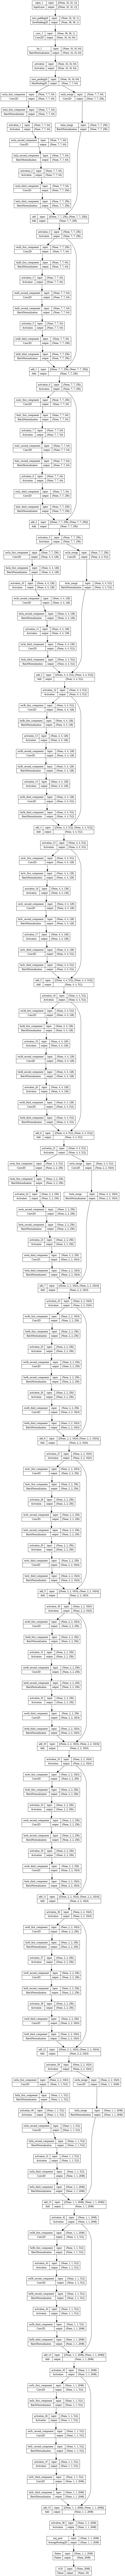

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

## TRAIN MODEL

In [ ]:
'''
from tensorflow.keras.models import model_from_json

# Load the model architecture from JSON
with open('/content/drive/MyDrive/JU ETCE Research under SSC mam/MNIST/resnet 50/model_architecture.json', 'r') as json_file:
    loaded_model_json = json_file.read()
from tensorflow.keras.utils import custom_object_scope
with custom_object_scope({'Involution': Involution}):
    # Load or use the model containing the 'Involution' layer
    model = model_from_json(loaded_model_json)
# Load the model weights
model.load_weights('/content/drive/MyDrive/JU ETCE Research under SSC mam/MNIST/resnet 50/model_weights.h5')

'''

"\nfrom tensorflow.keras.models import model_from_json\n\n# Load the model architecture from JSON\nwith open('/content/drive/MyDrive/JU ETCE Research under SSC mam/MNIST/resnet 50/model_architecture.json', 'r') as json_file:\n    loaded_model_json = json_file.read()\nfrom tensorflow.keras.utils import custom_object_scope\nwith custom_object_scope({'Involution': Involution}):\n    # Load or use the model containing the 'Involution' layer\n    model = model_from_json(loaded_model_json)\n# Load the model weights\nmodel.load_weights('/content/drive/MyDrive/JU ETCE Research under SSC mam/MNIST/resnet 50/model_weights.h5')\n\n"

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [ ]:
log_dir=".logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

training_history = model.fit(
    x_train_normalized,
    y_train,
    epochs=50,
    batch_size = 256,
    validation_data=(x_test_normalized, y_test),
    #callbacks=[tensorboard_callback]
)

Epoch 1/50
235/235 [==============================] - 38s 121ms/step - loss: 0.0551 - accuracy: 0.9827 - val_loss: 0.0416 - val_accuracy: 0.9877
Epoch 2/50
235/235 [==============================] - 25s 107ms/step - loss: 0.0398 - accuracy: 0.9874 - val_loss: 0.0372 - val_accuracy: 0.9892
Epoch 3/50
235/235 [==============================] - 25s 108ms/step - loss: 0.0305 - accuracy: 0.9906 - val_loss: 0.0321 - val_accuracy: 0.9894
Epoch 4/50
235/235 [==============================] - 23s 98ms/step - loss: 0.0240 - accuracy: 0.9925 - val_loss: 0.0277 - val_accuracy: 0.9907
Epoch 5/50
235/235 [==============================] - 23s 98ms/step - loss: 0.0195 - accuracy: 0.9937 - val_loss: 0.0278 - val_accuracy: 0.9918
Epoch 6/50
235/235 [==============================] - 23s 98ms/step - loss: 0.0153 - accuracy: 0.9954 - val_loss: 0.0306 - val_accuracy: 0.9906
Epoch 7/50
235/235 [==============================] - 26s 109ms/step - loss: 0.0128 - accuracy: 0.9961 - val_loss: 0.0327 - val_accur

In [ ]:
# # Save the model architecture to JSON
# model_json = model.to_json()
# with open('/content/drive/MyDrive/JU ETCE Research under SSC mam/MNIST/resnet 50/model_architecture.json', 'w') as json_file:
#     json_file.write(model_json)
# # Save the model weights
# model.save_weights('/content/drive/MyDrive/JU ETCE Research under SSC mam/MNIST/resnet 50/model_weights.h5')

## Model Evaluation

In [ ]:
train_loss, train_accuracy = model.evaluate(x_train_normalized, y_train)
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)

1875/1875 [==============================] - 20s 11ms/step - loss: 0.0244 - accuracy: 0.9924
Training loss:  0.024431992322206497
Training accuracy:  0.9924333095550537


In [ ]:
validation_loss, validation_accuracy = model.evaluate(x_test_normalized, y_test)
print('Validation loss: ', validation_loss)
print('Validation accuracy: ', validation_accuracy)

313/313 [==============================] - 3s 10ms/step - loss: 0.0542 - accuracy: 0.9856
Validation loss:  0.05424141883850098
Validation accuracy:  0.9855999946594238


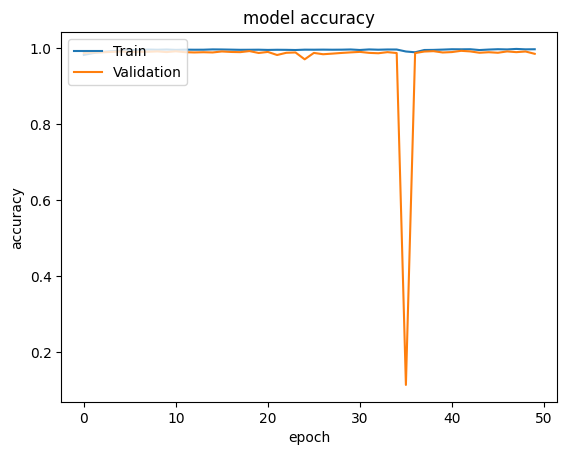

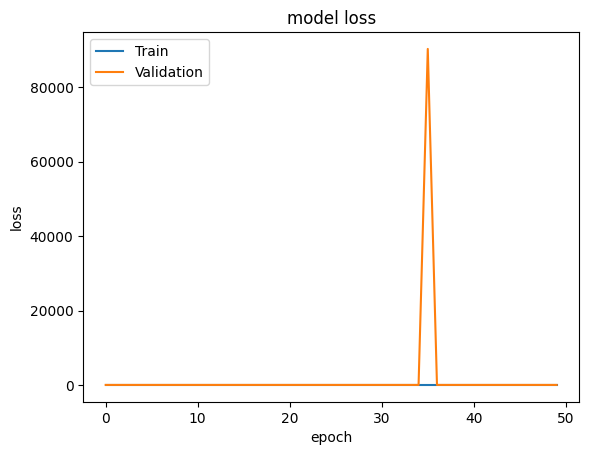

In [ ]:
import matplotlib.pyplot as plt

#will not work for pickled

# summarize history for accuracy
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
print(max(training_history.history['val_accuracy']))

0.9934999942779541


# Model Reload

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
from tensorflow.keras.models import model_from_json

model = tf.keras.models.load_model('/content/drive/MyDrive/JU_ETCE_Research_SSC/MNIST/resnet 50/best model.h5')
# with open('/content/drive/MyDrive/JU_ETCE_Research_SSC/FMNIST/invo resnet/model_architecture.json', 'r') as json_file:
#     loaded_model_json = json_file.read()
# from tensorflow.keras.utils import custom_object_scope
# with custom_object_scope({'Involution': Involution}):

#     model = model_from_json(loaded_model_json)

# model.load_weights('/content/drive/MyDrive/JU_ETCE_Research_SSC/FMNIST/invo resnet/model_weights.h5')
optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])

In [10]:
select_layers = [layer for layer in model.layers if layer.name[:4] == 'acti' or layer.name[:3] == 'inp']
select_layers=select_layers[::2]
len(select_layers)

25

0
1/1 [==============================] - 0s 147ms/step
1
1/1 [==============================] - 7s 7s/step
2
1/1 [==============================] - 0s 220ms/step
3
1/1 [==============================] - 0s 174ms/step
4


1/1 [==============================] - 0s 184ms/step
5


1/1 [==============================] - 0s 204ms/step
6
1/1 [==============================] - 0s 316ms/step
7
1/1 [==============================] - 0s 347ms/step
8
1/1 [==============================] - 0s 315ms/step
9
1/1 [==============================] - 0s 357ms/step
10
1/1 [==============================] - 0s 370ms/step
11
1/1 [==============================] - 0s 422ms/step
12
1/1 [==============================] - 0s 489ms/step
13
1/1 [==============================] - 1s 567ms/step
14
1/1 [==============================] - 1s 511ms/step
15
1/1 [==============================] - 1s 812ms/step
16
1/1 [==============================] - 1s 870ms/step
17
1/1 [==============================] - 1s 966ms/step
18
1/1 [==============================] - 1s 851ms/step
19
1/1 [==============================] - 1s 677ms/step
20
1/1 [==============================] - 1s 700ms/step
21
1/1 [==============================] - 1s 793ms/step
22
1/1 [==============================] - 1s 1s/step
23

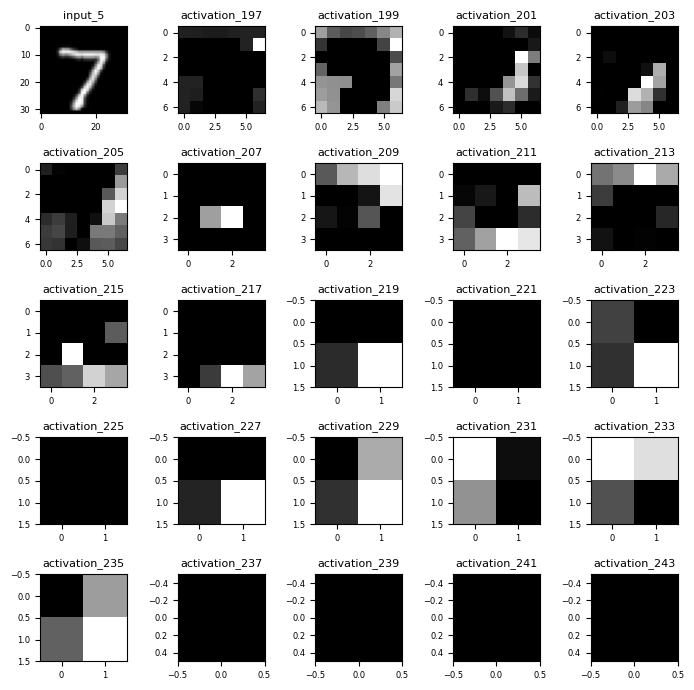

In [11]:
image=x_test_normalized[0]
grid_size = 5
fig, axs = plt.subplots(grid_size, grid_size, figsize=(7, 7))
for i,layer in enumerate(select_layers):
    print(i)
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=layer.output)
    intermediate_output = intermediate_model.predict(image[np.newaxis, ...])
    row = i // grid_size
    col = i % grid_size
    ax = axs[row, col]
    ax.imshow(intermediate_output[0, :, :, 0],cmap='gray')
    ax.set_title(layer.name,fontsize=8)
    ax.tick_params(axis='both', which='both', labelsize=6)
plt.subplots_adjust(hspace=0.5)
plt.savefig('invo_grid_mnist')
plt.tight_layout()
plt.show()


In [12]:
loss, accuracy = model.evaluate(x_test_normalized, y_test)

313/313 [==============================] - 6s 12ms/step - loss: 0.0503 - accuracy: 0.9837


In [13]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

313/313 [==============================] - 3s 8ms/step
Confusion Matrix:
[[ 979    0    0    0    0    0    0    0    1    0]
 [   1 1122    3    0    1    0    0    1    7    0]
 [   4    0 1023    0    0    0    1    0    4    0]
 [   3    0    2  993    0    6    0    3    3    0]
 [   0    0    0    0  972    0    1    1    3    5]
 [   4    0    0    6    1  875    1    1    2    2]
 [  16    2    0    0    3    1  934    0    2    0]
 [   1    2    4    0    3    0    0 1013    3    2]
 [   8    0    4    0    1    2    0    2  956    1]
 [   4    1    0    3    6    5    0   11    9  970]]


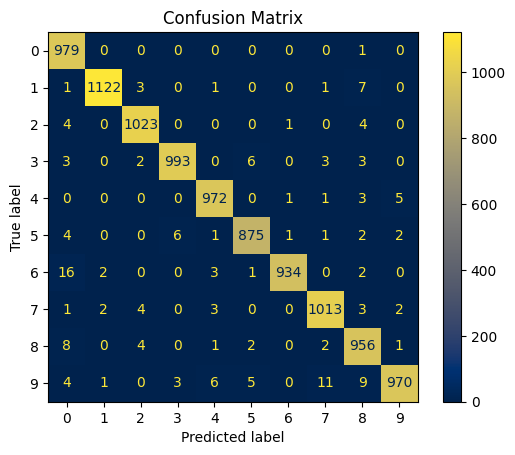

In [14]:
y_pred = model.predict(x_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)
#y_true_classes = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='cividis')
plt.title("Confusion Matrix")
plt.savefig('mnist_invo-resnet_cm.png')
plt.show()

# Plot confusion matrix



In [15]:
from sklearn.metrics import precision_score, f1_score, recall_score
precision = precision_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

Precision: 0.9838839415323504
F1 Score: 0.9837101393003279
Recall: 0.9837
